# 泛映射类型
字典和集合依赖于散列表的高速查询能力，其映射的抽象超类如图所示，非抽象映射类一般不会直接继承这些抽象基类，它们直接对dict或collections.UserDict进行扩展。可以使用isinstance判断对象是否是广义上的映射类型：isinstance(my_dict, abc.Mapping)。

#### 标准库所有映射都是直接利用dict实现的，因此它们有个共同点限制，即仅有可散列的数据类型才可作为映射键。
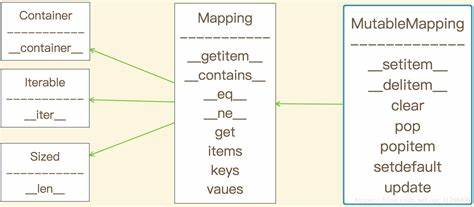
## 可散列类型
1.若对象可散列，则在其生命周期内hash值不变（需要实现__hash__方法和__eq__方法）

#### 2.相同对象（业务上的__eq__相等,==调用）的散列值必须相同，不同可散列对象hash若相等会造成冲突。

3.原子不可变类型（str、bytes、数值类型）都是可散列类型，frozenset也是（只能容纳可散列类型）可散列类型。

#### 4.若为元组，则其全部元素可散列，该元组可散列。

5.用户自定义类型对象都是可散列的，默认的\__hash__和\__eq__都使用id()分别作为散列值和==依据，因此默认情况下自定义类型对象永不相等（除了和自己比）。

In [18]:
# key必须可散列
from collections import OrderedDict
a = OrderedDict({1:2, 3:'v', {2}:5})

TypeError: unhashable type: 'set'

## \__hash__和\__eq__
#### 1.\__eq__用于使用==时调用，用于判断对象是否相同。\__hash__用于返回散列值（int），用于应对哈希表的索引查找。当使用哈希表查找时，首先调用\__hash__得到对象的散列值进而得到表索引，如果对应索引位置已有元素则进一步调用\__eq__判断两者是否相同。
2.显然在利用内置set和mapping时，元素的增删改查都会涉及到这两个方法。因而若__对象相同则hash值必须相同__，否则将会有相同的对象在哈希表结构中。

3.自定义可散列类若重写\__eq__方法则需要重写\__hash__（否则可能两对象相等但散列值不等，因为默认\__hash__返回的值永不相同），否则该类被视为不可散列且\__hash__值被编译器设置为None以屏蔽。

#### 4.自定义可散列类的\__hash__最佳实践是使用其在\__eq__中依赖的属性，将他们封装为元组后返回元组的hash值。但是这些属性必须是可散列的。

5.自定义类对象的是否相等如果必须依赖于某不可散列属性，则该类对象显然不可散列（由于相等对象散列值必须相同，因此散列值的生成必须由判断对象是否相同所依赖的全部属性共同生成，也就是通常4中的实践方法），无需实现\__hash__（会被python自动屏蔽）。

6.使用默认\__hash__和\__eq__一定是散列类型很好理解，因为对象的相等完全依赖于内存id，散列值也同样如此，满足对象相同则hash值必须相同。

In [10]:
class Foo:
    def __init__(self, item):
        self.item = item

    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.item == other.item
        else:
            return False
    
    def __hash__(self):
        return hash(self.item)
    
# 若不覆盖__hash__，或item不可散列，则下列代码将报错。
f1 = Foo(1)
f2 = Foo(2)
f3 = Foo(3)
print(set([f1, f2, f3]))

{<__main__.Foo object at 0x00000237A86787F0>, <__main__.Foo object at 0x00000237A8678860>, <__main__.Foo object at 0x00000237A86787B8>}


## dict（字典）
用的最多的是dict，常见构造方法如下：

In [14]:
a = dict(one=1, two=2, three=3)
b = {'one':1, 'two':2, 'three':3}
c = dict(zip(['one', 'two', 'three'], [1, 2, 3]))
d = dict([('one', 1), ('two', 2), ('three', 3)])
e = dict({'one':1, 'two':2, 'three':3})

## 其他常见映射
dict、collections.defaultdict、collections.OrderedDict

python中大多数内置映射方法会首先检查传入的对象是否有keys方法，有的话会将其当成映射对象处理，否则当做含有键值对(key, value)的可迭代对象处理。update方法也遵循于此，此方法常用于添加行的映射或更改已有映射。
## setdefault
setdefault方法包含设置给定值（如果key不存在）并返回该值的双重功能，有时比利用get(key, default)更加高效。

In [15]:
index={}
line1 = index.get('line1',[])
line1.append("I'm ok")
index['line1'] = line1
# 等价于
index.setdefault('line1', []).append("I'm ok") # 于下面相比，避免了重复的键搜索
# 等价于
if 'line1' not in index:
    index['line1'] = []
index['line1'].append("I'm ok")

## defaultdict（默认值字典）
有时当字典无key时只想单纯的获取一个默认值，defaultdict可为其指定默认值callable生成对象,但仅有通过[]索引来调用\__getitem__时才起作用，否则为None（get方法返回值）
#### []调用\__getitem__时找不到对应key，python会调用\__missing__方法，因此最终是该方法内实现了默认值生成策略。

In [20]:
from collections import defaultdict
dd = defaultdict(list)
dd['a']

[]

## \__missing__
#### 所有映射在使用[]进而调用\__getitem__(\__missing__只会被\__getitem__调用)找不到键的时候python都会尝试调用该方法，但是基类dict并没有定义该方法。

有时希望一个仅含有str的key的容器映射用于查询，另外希望该映射对数字key和其str值等价以方便查询，此时就需要\__missing__方法在使用数字key无效时将其转为str再次尝试：

In [6]:
# 继承dict基类
class StrKeyDict0(dict):
    def __missing__(self, key):
        # 这里必须先检查key的类型作为出口而不可仅用return self[str(key)]，因为若str(key)不存在则出现无限递归。
        if isinstance(key, str):
            raise KeyError(key)
        return self[str(key)]
    
    def get(self, key, default=None):
        # 这里get方法最终委托给[],也就拥有调用__missing__的能力。
        try:
            return self[key]
        except KeyError:
            return default
        
    # 这里不能直接使用key in self or str(key) in self，这样会造成__contain__循环递归调用。
    def __contain__(self, key):
        return key in self.keys() or str(key) in self.keys()
    
    # 存在无限递归问题
    def __setitem__(self, key, item):
        self[str(key)] = item

In [5]:
dd = StrKeyDict0((('1', 1), ('2', 2), ('3', 3)))
print(dd[1])
dd[1] = 5

1


RecursionError: maximum recursion depth exceeded

## 其他常见映射
### collections.OrderedDict
有序字典显然key存放于能保持顺序的结构而非利用哈希表，如平衡红黑树（按理说非hashtable的映射应该无需key必须可散列，只要能比较就行）。
### collections.ChainMap
### collections.Counter
这个映射给每个键准备了整数计数器，每次更新键会使其计数+1。
### collections.UserDict
用纯python将dict重新实现的映射。一般来说创建自定义映射以UserDict为基类较方便，因为若以Dict为基类，其某些方法会走‘捷径’导致我们需要用python重写，UserDict无此问题（UserDict不是dict子类）。

UserDict内有一个data的属性，是dict的实例，用于存放数据，因此UserDict\__getitem__将委托给data属性。这样一来可避免上例中\__contain__内必须用key in self.keys()而非key in mapping这种更python的实现风格（相当于用data属性存放数据，同时能利用data作为dict的特性，有更多灵活性）。

In [9]:
from collections import UserDict
# 利用UserDict内的dict类属性data，能够编写更加python风格的代码而无需像StrKeyDict0要处理递归问题。
class StrKeyDict(UserDict):
    def __missing__(self, key):
        # 不管怎样再以str查一遍（但是如果key已经是str会浪费一次查询）
        return self.data[str(key)]
    
    # 从Mapping中继承到的get方法逻辑如下：因此无需实现。
    def get(self, key, default=None):
        # 这里get方法最终委托给[],也就拥有调用__missing__的能力。
        try:
            return self[key]
        except KeyError:
            return default
        
    # 这里直接使用key in dict。
    def __contain__(self, key):
        return key in self.data or str(key) in self.keys()
    
    # 不存在无限递归问题
    def __setitem__(self, key, item):
        self.data[str(key)] = item

## 不可变映射
有时希望一个映射对象只读，仅有查询展示数据的功能。可以使用types模块的MappingProxyType，它会将一个标准库的映射封装为只读视图代理（会随着原映射给变而动态更新）

In [13]:
from types import MappingProxyType
d = {1: 'a'}
d_p = MappingProxyType(d)
d_p[1] = 'b'

TypeError: 'mappingproxy' object does not support item assignment

# 集合
集合本质是许多唯一对象的聚集，可用于去重。set内元素必须可散列，set是可变的因此不能散列，但frozenset可以（frozenset只能存放可散列元素）
## 集合中缀运算
a | b：表示合集，a & b：表示交集，a - b：表示差集
## set字面量
利用set字面量代码更已读且效率更高

In [14]:
# BUILD_SET直接完成集合创建，而第二个例子需要LOAD_NAME、BUILD_LIST、CALL_FUNCTION三步
from dis import dis
print(dis('{1}'))
print(dis('set([1])'))

  1           0 LOAD_CONST               0 (1)
              2 BUILD_SET                1
              4 RETURN_VALUE
None
  1           0 LOAD_NAME                0 (set)
              2 LOAD_CONST               0 (1)
              4 BUILD_LIST               1
              6 CALL_FUNCTION            1
              8 RETURN_VALUE
None


# python中dict和set类高效原因
## 1.dict和set的key存储方式
使用散列表，因此含有1000个元素的dict和1000w个元素的dict的查询，后者仅慢67%（set同理），当然CPython也有相应优化。

python使用的散列表是一个稀疏数组（bucket）。dict中每个键值对都占用一个位置（存的是引用），因为每个数组位置大小相同，因此可以使用偏移量来读取某个位置的数据，每个偏移量的计算依赖于key的散列值。

python会保证bucket有约1/3的剩余位置，若达到阈值则进行新建扩充。
## 2.散列表算法
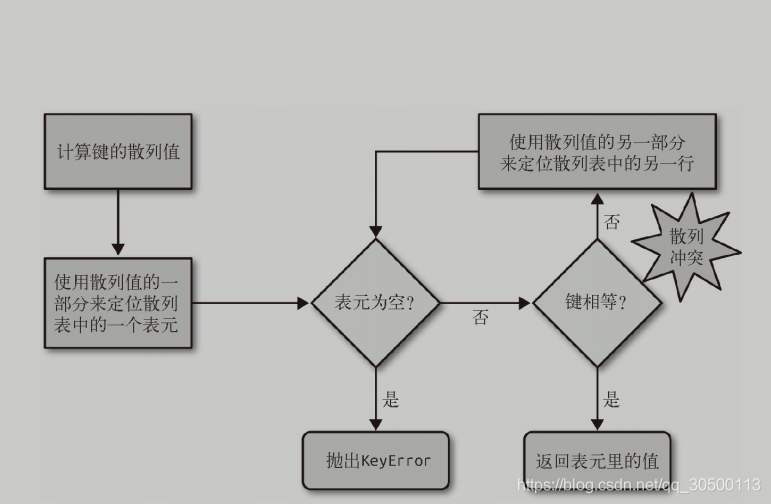
#### python得到search_key的hash值后（int），使用其低若干位（具体取几位视bucket大小而定）当做偏移量去bucket中寻找，若为空则抛出KeyError，若非空则进一步调用\__eq__判断两者是否相等，若相等才算search成功。当然也可能两者不相等（散列冲突，因为没规定不等对象散列值必须不同），此时python会使用search_key更多位数的散列值进行再次搜索，直到使用全部的散列值。

在需要插入新值时（插入key），python会参照bucket的拥挤程度决定是否扩容，若扩容，则用作计算偏移量的散列值位数会随之增加，这样可减少散列冲突。
## 3.依赖散列表的dict和set的问题
由于散列表稀疏的特性，因此其空间利用率较低，如果仅仅是希望存储较大数量的数据则更适合用元素或具名元组

#### 元素在散列表中的位置取决于key的添加顺序，同样的数据如果存入空dict的顺序不同，其key的存储顺序也可能不同（原因是由于key发生了散列冲突），因此key在散列表中的顺序是不可控的
#### 向散列表中添加新键可能导致散列表扩容，并把已有的key添加到新的散列表中，那么已有的key在新的更大散列表中的分布、顺序可能改变。
#### 如果在遍历字典的过程中添加了新的键值对，可能导致散列表扩容从而使得原有键值对分布发生变化，此时继续遍历可能会跳过甚至重新遇到某些键值对。

python3中，keys(),items(),values()方法返回的都是动态字典视图，也就是这些方法返回的值更像集合。python2返回的是列表视图

In [32]:
a = {1:2,2:2}
for k in a.values():
    print(k)

2
2
